In [234]:
import pandas as pd
import zipfile
import os
import numpy as np
from scipy.io import arff
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from math import pi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn

In [ ]:
zip_file_path = '/content/risk+factor+prediction+of+chronic+kidney+disease.zip'

In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

In [ ]:
extracted_files = os.listdir('/content/extracted_data')
print("Extracted files:", extracted_files)

Extracted files: ['ckd-dataset-v2.csv']


In [ ]:
csv_file_path = '/content/extracted_data/ckd-dataset-v2.csv'

In [ ]:
df = pd.read_csv(csv_file_path)

In [ ]:
df.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


In [ ]:
missing_values = df.isnull().sum()
print("\nMissing values in each column:\n", missing_values)


Missing values in each column:
 bp (Diastolic)    1
bp limit          1
sg                1
al                1
class             1
rbc               1
su                1
pc                1
pcc               1
ba                1
bgr               1
bu                1
sod               1
sc                1
pot               1
hemo              1
pcv               1
rbcc              1
wbcc              1
htn               1
dm                1
cad               1
appet             1
pe                1
ane               1
grf               1
stage             1
affected          0
age               0
dtype: int64


In [ ]:
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

<ipython-input-9-78b9e3dcd75f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)


In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column].fillna(df[column].mean(), inplace=True)

In [ ]:
print("\nMissing values after filling:\n", df.isnull().sum())


Missing values after filling:
 bp (Diastolic)    0
bp limit          0
sg                0
al                0
class             0
rbc               0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sod               0
sc                0
pot               0
hemo              0
pcv               0
rbcc              0
wbcc              0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
grf               0
stage             0
affected          0
age               0
dtype: int64


In [ ]:
print("\nCleaned DataFrame:\n", df.head())


Cleaned DataFrame:
   bp (Diastolic)  bp limit             sg        al     class       rbc  \
0       discrete  discrete       discrete  discrete  discrete  discrete   
1              1         0  1.019 - 1.021       < 0       ckd         0   
2              0         0  1.019 - 1.021     1 - 1       ckd         0   
3              0         0  1.009 - 1.011       < 0       ckd         0   
4              0         0  1.009 - 1.011       ≥ 4       ckd         1   

         su        pc       pcc        ba  ...       htn        dm       cad  \
0  discrete  discrete  discrete  discrete  ...  discrete  discrete  discrete   
1       < 0         0         0         0  ...         0         0         0   
2       < 0         0         0         0  ...         0         0         0   
3       < 0         0         0         0  ...         0         0         0   
4       < 0         1         0         1  ...         0         0         0   

      appet        pe       ane                

In [ ]:
df = df.drop(0).reset_index(drop=True)

In [ ]:
df = df.replace(['discrete', 'meta', 'class', '< 0'], np.nan)

In [ ]:
def get_mid_value(value):
    if pd.isna(value):  # Check if the value is NaN
        return np.nan
    elif isinstance(value, str):  # Only proceed if the value is a string
        # Check if the value contains a range (e.g., "1.019 - 1.021")
        if '-' in value:
            try:
                start, end = value.split(' - ')
                return (float(start) + float(end)) / 2
            except ValueError:
                return np.nan  # Return NaN if conversion fails
        # Handle '≥' or '<' symbols
        elif '≥' in value:
            try:
                return float(value.replace('≥ ', ''))
            except ValueError:
                return np.nan
        elif '<' in value:
            try:
                return float(value.replace('< ', ''))
            except ValueError:
                return np.nan
        else:
            # Attempt to convert the standalone string to float
            try:
                return float(value)
            except ValueError:
                return np.nan
    else:
        return value

In [ ]:
df['sg'] = df['sg'].apply(get_mid_value)
df['grf'] = df['grf'].apply(get_mid_value)

In [ ]:
print("Cleaned DataFrame:\n", df.head())

Cleaned DataFrame:
   bp (Diastolic) bp limit    sg     al class rbc   su pc pcc ba  ... htn dm  \
0              1        0  1.02    NaN   ckd   0  NaN  0   0  0  ...   0  0   
1              0        0  1.02  1 - 1   ckd   0  NaN  0   0  0  ...   0  0   
2              0        0  1.01    NaN   ckd   0  NaN  0   0  0  ...   0  0   
3              0        0  1.01    ≥ 4   ckd   1  NaN  1   0  1  ...   0  0   
4              1        1  1.01  3 - 3   ckd   0  NaN  0   0  0  ...   0  0   

  cad appet pe ane       grf stage affected   age  
0   0     0  0   0   26.6175    s1      NaN   NaN  
1   0     0  0   0  227.9440    s1        1  < 12  
2   0     0  0   0  227.9440    s1        1  < 12  
3   0     1  0   0  139.8635    s1        1  < 12  
4   0     0  0   0  139.8635    s1        1  < 12  

[5 rows x 29 columns]


In [ ]:
columns_to_clean = ['al', 'age']

In [ ]:
for column in columns_to_clean:
    df[column] = df[column].apply(get_mid_value)

In [ ]:
print("Further Cleaned DataFrame:\n", df.head())

Further Cleaned DataFrame:
   bp (Diastolic) bp limit    sg   al class rbc   su pc pcc ba  ... htn dm cad  \
0              1        0  1.02  NaN   ckd   0  NaN  0   0  0  ...   0  0   0   
1              0        0  1.02  1.0   ckd   0  NaN  0   0  0  ...   0  0   0   
2              0        0  1.01  NaN   ckd   0  NaN  0   0  0  ...   0  0   0   
3              0        0  1.01  4.0   ckd   1  NaN  1   0  1  ...   0  0   0   
4              1        1  1.01  3.0   ckd   0  NaN  0   0  0  ...   0  0   0   

  appet pe ane       grf stage affected   age  
0     0  0   0   26.6175    s1      NaN   NaN  
1     0  0   0  227.9440    s1        1  12.0  
2     0  0   0  227.9440    s1        1  12.0  
3     1  0   0  139.8635    s1        1  12.0  
4     0  0   0  139.8635    s1        1  12.0  

[5 rows x 29 columns]


Label Encoding:

In [ ]:
label_enc = LabelEncoder()
categorical_cols = ['class', 'stage']  # Add any other categorical columns if needed
for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col].astype(str))

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bp (Diastolic)  201 non-null    object 
 1   bp limit        201 non-null    object 
 2   sg              201 non-null    float64
 3   al              201 non-null    float64
 4   class           201 non-null    int64  
 5   rbc             201 non-null    object 
 6   su              201 non-null    object 
 7   pc              201 non-null    object 
 8   pcc             201 non-null    object 
 9   ba              201 non-null    object 
 10  bgr             201 non-null    object 
 11  bu              201 non-null    object 
 12  sod             201 non-null    object 
 13  sc              201 non-null    object 
 14  pot             201 non-null    object 
 15  hemo            201 non-null    object 
 16  pcv             201 non-null    object 
 17  rbcc            201 non-null    obj

In [ ]:
binary_columns = ['rbc', 'su', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'bp (Diastolic)', 'bp limit']
for col in binary_columns:
    df[col] = df[col].apply(lambda x: 1 if x in ['yes', '1'] else 0 if x in ['no', '0'] else x)

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bp (Diastolic)  201 non-null    int64  
 1   bp limit        201 non-null    int64  
 2   sg              201 non-null    float64
 3   al              201 non-null    float64
 4   class           201 non-null    int64  
 5   rbc             201 non-null    int64  
 6   su              201 non-null    int64  
 7   pc              201 non-null    int64  
 8   pcc             201 non-null    int64  
 9   ba              201 non-null    int64  
 10  bgr             201 non-null    int64  
 11  bu              201 non-null    int64  
 12  sod             201 non-null    int64  
 13  sc              201 non-null    int64  
 14  pot             201 non-null    int64  
 15  hemo            201 non-null    int64  
 16  pcv             201 non-null    int64  
 17  rbcc            201 non-null    int

Standard Scalar:

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

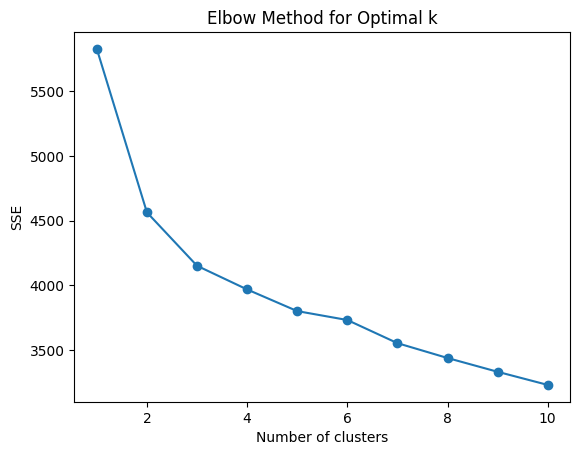

In [ ]:
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
optimal_k = 3  # replace with the optimal k from elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(scaled_data)

In [ ]:
sil_score = silhouette_score(scaled_data, labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.1870247896761597


In [ ]:
df['Cluster'] = labels
print(df.groupby('Cluster').mean())

         bp (Diastolic)  bp limit        sg        al     class       rbc  \
Cluster                                                                     
0              0.579545  0.840909  1.015216  2.011364  0.000000  0.125000   
1              0.459459  0.445946  1.021284  1.986486  0.972973  0.000000   
2              0.615385  1.128205  1.015282  2.717949  0.000000  0.358974   

               su        pc       pcc        ba  ...       htn        dm  \
Cluster                                          ...                       
0        1.159091  0.159091  0.113636  0.022727  ...  0.511364  0.488636   
1        1.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2        1.076923  0.794872  0.435897  0.230769  ...  0.846154  0.692308   

              cad     appet        pe       ane         grf     stage  \
Cluster                                                                 
0        0.125000  0.238636  0.170455  0.102273   46.063772  2.295455   
1        0.000

In [ ]:
optimal_k = 4  # replace with the optimal k from elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(scaled_data)

In [ ]:
sil_score = silhouette_score(scaled_data, labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.18819102297809903


In [ ]:
df['Cluster'] = labels
print(df.groupby('Cluster').mean())

         bp (Diastolic)  bp limit        sg        al     class       rbc  \
Cluster                                                                     
0              0.812500  1.343750  1.017688  2.437500  0.000000  0.375000   
1              0.465753  0.452055  1.021438  1.986301  0.986301  0.000000   
2              0.368421  0.736842  1.012737  2.947368  0.000000  0.263158   
3              0.545455  0.792208  1.014766  1.961039  0.000000  0.103896   

               su        pc       pcc        ba  ...       htn        dm  \
Cluster                                          ...                       
0        1.031250  0.468750  0.156250  0.000000  ...  0.875000  0.656250   
1        1.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2        1.315789  0.842105  0.631579  0.526316  ...  0.736842  0.684211   
3        1.129870  0.181818  0.129870  0.012987  ...  0.467532  0.467532   

              cad     appet        pe       ane         grf     stage  \
Cluster

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [ ]:
df['Cluster'] = kmeans.fit_predict(scaled_data)

In [ ]:
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
 [[ 0.17922295  0.50650144 -0.42410906  0.88274521 -0.74708737  0.73949625
  -0.01182455  1.35684924  0.84082189  0.80070104 -0.01709035 -1.12414705
  -0.50446773 -1.197683    0.05768697  0.59717352 -0.87627742 -0.76160524
  -0.40790886  0.93174192  0.70516117  0.57660877  0.75389774  0.92871106
   1.21918664 -0.70278352  1.10254088  0.74708737  0.21703549]
 [ 0.04201019  0.08077122 -0.46859575 -0.20579336 -0.74708737  0.00623817
   0.16034732 -0.12346808 -0.02314213 -0.1395406  -0.09763894  0.00491485
  -0.22804873  0.12404016 -0.07558983 -0.50575391 -0.36232082 -0.23530507
   0.10637402  0.28867954  0.3305674   0.05440006  0.10613436 -0.00452391
  -0.1523937  -0.48842288  0.34346214  0.74708737  0.28459288]
 [ 0.60991595  0.11821461  0.7028484  -0.20579336  1.1246219  -0.37688918
  -0.17764321 -0.53708616 -0.3939193  -0.24061325  0.148502    0.63659069
   0.35644256  0.45684815  0.05768697  0.1432295   0.93389963  0.58768097
  -0.18614731 -0.79633306 -0.73099326 -0.3

In [ ]:
cluster_summary = df.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
          bp (Diastolic)  bp limit        sg        al     class       rbc  \
Cluster                                                                     
0              0.631579  1.157895  1.015421  2.736842  0.000000  0.368421   
1              0.563218  0.816092  1.015207  2.000000  0.000000  0.126437   
2              0.846154  0.846154  1.020846  2.000000  0.897436  0.000000   
3              0.081081  0.081081  1.021297  2.000000  1.000000  0.000000   

               su        pc       pcc        ba  ...       htn        dm  \
Cluster                                          ...                       
0        1.078947  0.789474  0.421053  0.236842  ...  0.842105  0.684211   
1        1.160920  0.172414  0.126437  0.022989  ...  0.528736  0.505747   
2        1.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
3        1.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

              cad     appet        pe       ane         grf   

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

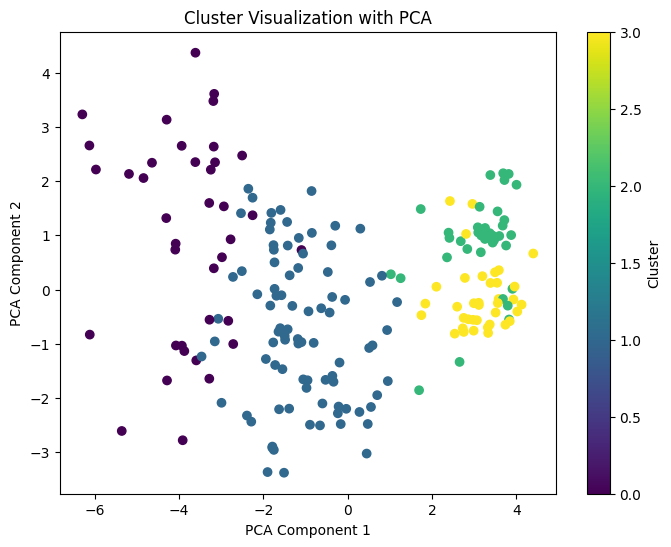

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Cluster'], cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA')
plt.colorbar(label='Cluster')
plt.show()

Some clusters are tightly grouped, indicating that data points within these clusters are similar. For example, the yellow cluster on the right appears compact, which implies high cohesion.

Fit KMeans Model and Obtain Cluster Labels

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)  # Set random_state for reproducibility
kmeans.fit(df)

KMeans(n_clusters=4, random_state=0)

In [ ]:
df['Cluster'] = kmeans.labels_

Cluster Profiling

Mean of each feature per cluster

In [ ]:
cluster_profile = df.groupby('Cluster').mean()
print("Cluster Profiles:")
print(cluster_profile)

Cluster Profiles:
         bp (Diastolic)  bp limit        sg        al     class       rbc  \
Cluster                                                                     
0              0.592593  0.907407  1.015852  2.222222  0.037037  0.203704   
1              0.363636  0.363636  1.020773  2.000000  0.863636  0.000000   
2              0.488889  0.666667  1.018356  2.022222  0.644444  0.044444   
3              0.576923  0.576923  1.019808  2.115385  0.769231  0.038462   

               su        pc       pcc        ba  ...       htn        dm  \
Cluster                                          ...                       
0        1.101852  0.370370  0.240741  0.074074  ...  0.666667  0.564815   
1        1.000000  0.000000  0.000000  0.000000  ...  0.045455  0.045455   
2        1.133333  0.088889  0.022222  0.044444  ...  0.111111  0.133333   
3        1.000000  0.038462  0.000000  0.038462  ...  0.000000  0.076923   

              cad     appet        pe       ane         grf   

bp (Diastolic) or su (sugar levels) is higher in a certain cluster, that cluster may represent a group with a higher risk of kidney issues.

Visualize the Cluster Profiles:

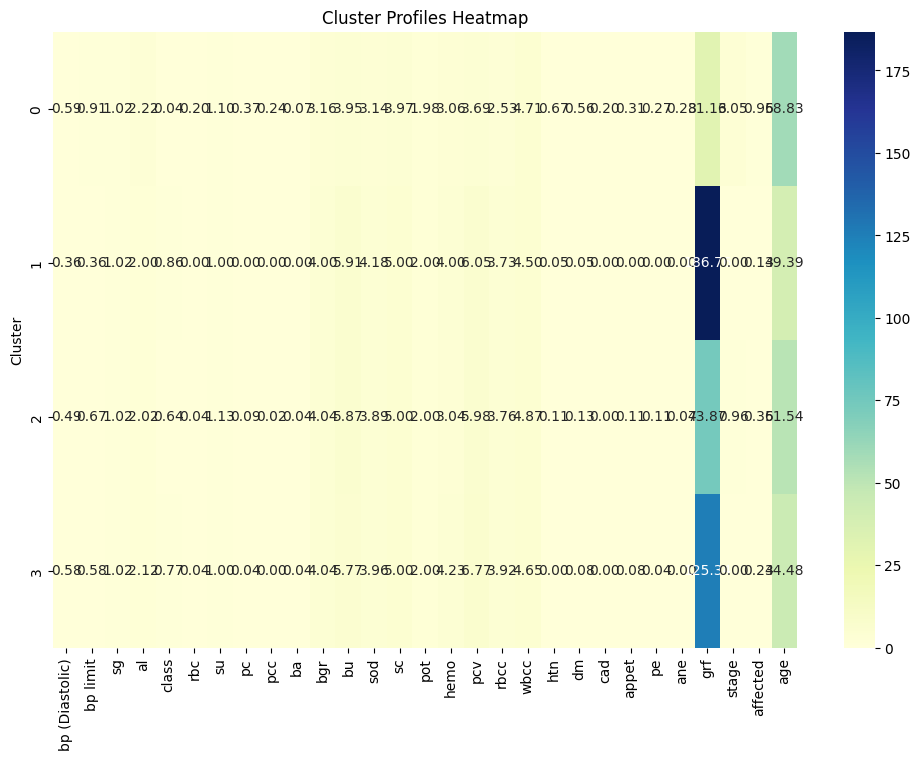

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cluster Profiles Heatmap")
plt.show()

In [ ]:
standardized_profile = StandardScaler().fit_transform(cluster_profile)
standardized_profile = pd.DataFrame(standardized_profile, index=cluster_profile.index, columns=cluster_profile.columns)

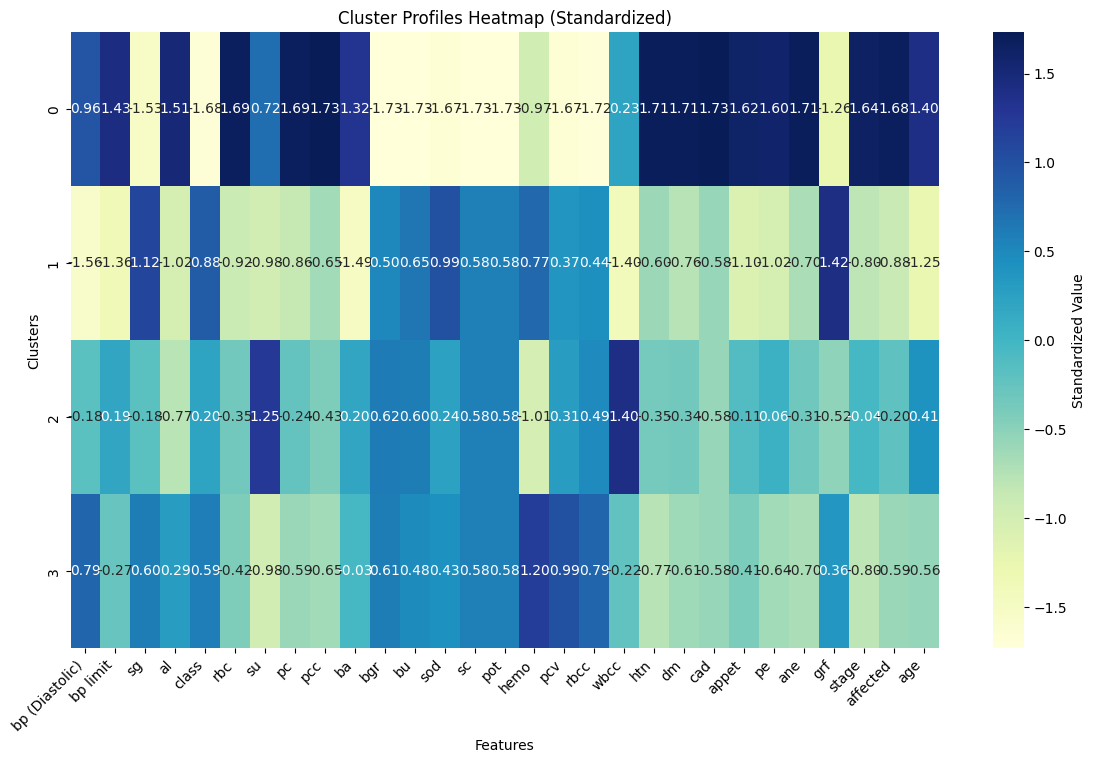

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(standardized_profile, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Standardized Value'})
plt.title("Cluster Profiles Heatmap (Standardized)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha="right")
plt.show()

Rador Plot:

In [ ]:
df = cluster_profile.reset_index()

In [ ]:
num_clusters = df.shape[0]
num_features = df.shape[1] - 1

In [ ]:
def make_radar_chart(data, categories, title):
    # Number of variables we're plotting
    N = len(categories)

    # Set up the angle of each axis in the plot (we divide the plot by the number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    for i in range(len(data)):
        values = data[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


In [ ]:
categories = list(df.columns[1:])

In [ ]:
data = [df.iloc[i, 1:].values for i in range(num_clusters)]

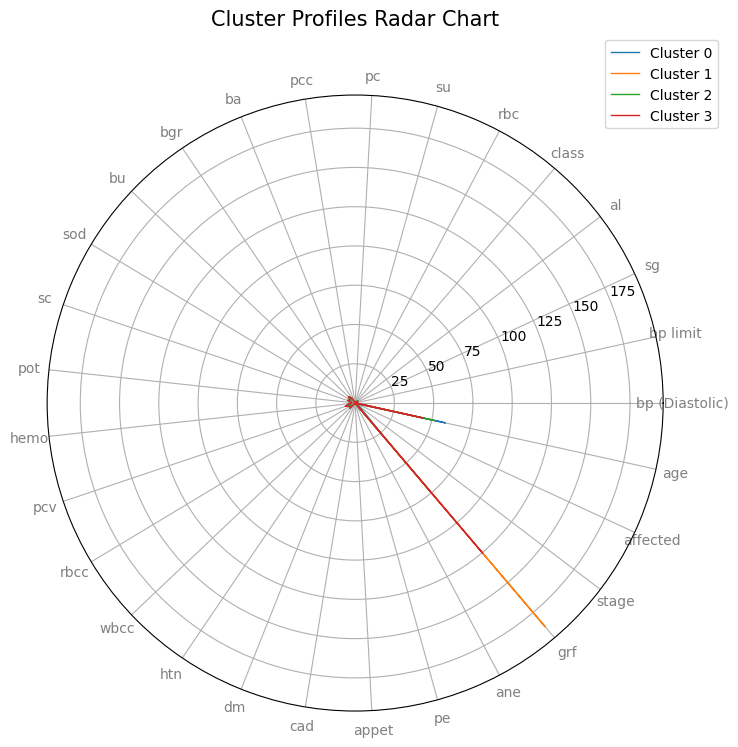

In [ ]:
make_radar_chart(data, categories, title="Cluster Profiles Radar Chart")

Hierarchical Clustering

In [ ]:
features = df[['bp (Diastolic)', 'sg', 'al', 'rbc', 'sod', 'age']]

In [ ]:
linked = linkage(features, method='ward')

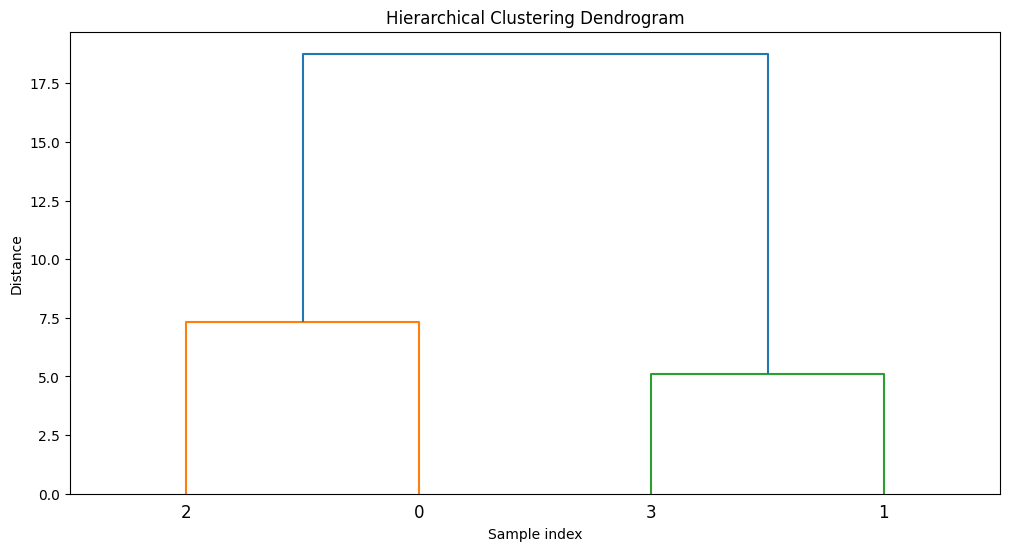

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
n_clusters = 4  # You can change this based on your analysis
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(features)

In [ ]:
df['hierarchical_cluster'] = agglo_labels

In [ ]:
print(df.head())

   Cluster  bp (Diastolic)  bp limit        sg        al     class       rbc  \
0        0        0.592593  0.907407  1.015852  2.222222  0.037037  0.203704   
1        1        0.363636  0.363636  1.020773  2.000000  0.863636  0.000000   
2        2        0.488889  0.666667  1.018356  2.022222  0.644444  0.044444   
3        3        0.576923  0.576923  1.019808  2.115385  0.769231  0.038462   

         su        pc       pcc  ...        dm       cad     appet        pe  \
0  1.101852  0.370370  0.240741  ...  0.564815  0.203704  0.305556  0.268519   
1  1.000000  0.000000  0.000000  ...  0.045455  0.000000  0.000000  0.000000   
2  1.133333  0.088889  0.022222  ...  0.133333  0.000000  0.111111  0.111111   
3  1.000000  0.038462  0.000000  ...  0.076923  0.000000  0.076923  0.038462   

        ane         grf     stage  affected        age  hierarchical_cluster  
0  0.277778   31.161307  3.046296  0.962963  58.828704                     2  
1  0.000000  186.763273  0.000000  0.136

In [ ]:
n_clusters = 3  # You can change this based on your analysis
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(features)

In [ ]:
df['hierarchical_cluster'] = agglo_labels

In [ ]:
print(df.head())

   Cluster  bp (Diastolic)  bp limit        sg        al     class       rbc  \
0        0        0.592593  0.907407  1.015852  2.222222  0.037037  0.203704   
1        1        0.363636  0.363636  1.020773  2.000000  0.863636  0.000000   
2        2        0.488889  0.666667  1.018356  2.022222  0.644444  0.044444   
3        3        0.576923  0.576923  1.019808  2.115385  0.769231  0.038462   

         su        pc       pcc  ...        dm       cad     appet        pe  \
0  1.101852  0.370370  0.240741  ...  0.564815  0.203704  0.305556  0.268519   
1  1.000000  0.000000  0.000000  ...  0.045455  0.000000  0.000000  0.000000   
2  1.133333  0.088889  0.022222  ...  0.133333  0.000000  0.111111  0.111111   
3  1.000000  0.038462  0.000000  ...  0.076923  0.000000  0.076923  0.038462   

        ane         grf     stage  affected        age  hierarchical_cluster  
0  0.277778   31.161307  3.046296  0.962963  58.828704                     2  
1  0.000000  186.763273  0.000000  0.136

In [ ]:
features = df[['bp (Diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc', 'pcc', 'dm', 'cad', 'age']]

In [ ]:
def plot_clusters(data, cluster_labels, k, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data['bp (Diastolic)'], y=data['age'], hue=cluster_labels, palette='viridis', legend='full')
    plt.title(f'{title} (k={k})')
    plt.xlabel('BP (Diastolic)')
    plt.ylabel('Age')
    plt.legend(title='Cluster')
    plt.show()

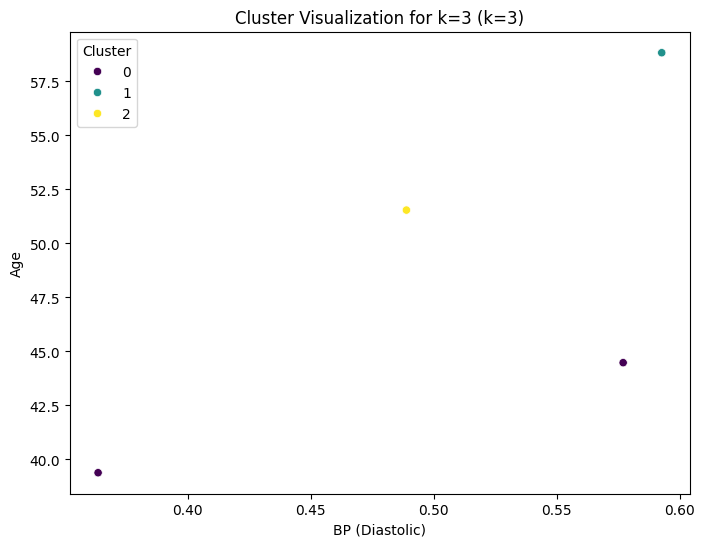

In [ ]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_3 = kmeans_3.fit_predict(features)
plot_clusters(features, labels_3, k=3, title='Cluster Visualization for k=3')

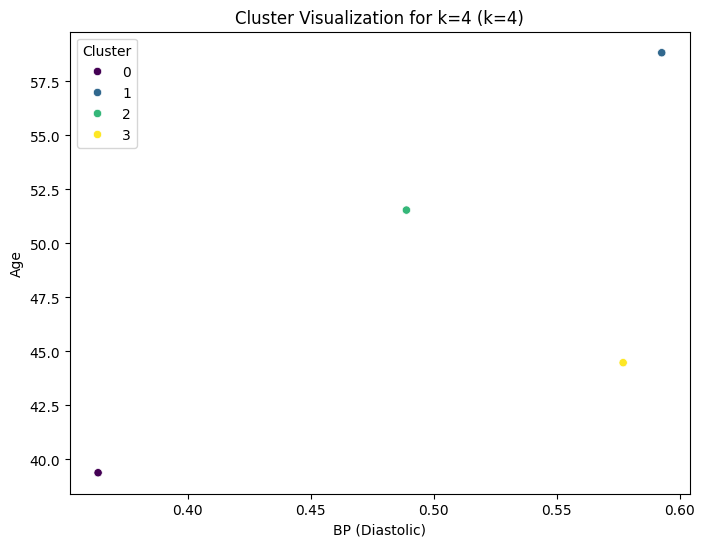

In [ ]:
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4 = kmeans_4.fit_predict(features)
plot_clusters(features, labels_4, k=4, title='Cluster Visualization for k=4')

In [ ]:
centroids_3 = pd.DataFrame(kmeans_3.cluster_centers_, columns=features.columns)
centroids_4 = pd.DataFrame(kmeans_4.cluster_centers_, columns=features.columns)

In [ ]:
print("Centroids for k=3:")
print(centroids_3)

Centroids for k=3:
   bp (Diastolic)  bp limit        sg        al       rbc        su        pc  \
0        0.470280  0.470280  1.020290  2.057692  0.019231  1.000000  0.019231   
1        0.592593  0.907407  1.015852  2.222222  0.203704  1.101852  0.370370   
2        0.488889  0.666667  1.018356  2.022222  0.044444  1.133333  0.088889   

        pcc        dm       cad        age  
0  0.000000  0.061189  0.000000  41.933566  
1  0.240741  0.564815  0.203704  58.828704  
2  0.022222  0.133333  0.000000  51.544444  


In [ ]:
print("\nCentroids for k=4:")
print(centroids_4)


Centroids for k=4:
   bp (Diastolic)  bp limit        sg        al       rbc        su        pc  \
0        0.363636  0.363636  1.020773  2.000000  0.000000  1.000000  0.000000   
1        0.592593  0.907407  1.015852  2.222222  0.203704  1.101852  0.370370   
2        0.488889  0.666667  1.018356  2.022222  0.044444  1.133333  0.088889   
3        0.576923  0.576923  1.019808  2.115385  0.038462  1.000000  0.038462   

        pcc        dm       cad        age  
0  0.000000  0.045455  0.000000  39.386364  
1  0.240741  0.564815  0.203704  58.828704  
2  0.022222  0.133333  0.000000  51.544444  
3  0.000000  0.076923  0.000000  44.480769  


In [ ]:
centroids_df = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'bp (Diastolic)': [0.363636, 0.592593, 0.488889, 0.576923],
    'bp limit': [0.363636, 0.907407, 0.666667, 0.576923],
    'sg': [1.020773, 1.015852, 1.018356, 1.019808],
    'al': [2.000000, 2.222222, 2.022222, 2.115385],
    'rbc': [0.000000, 0.203704, 0.044444, 0.038462],
    'su': [1.000000, 1.101852, 1.133333, 1.000000],
    'pc': [0.000000, 0.370370, 0.088889, 0.038462],
    'pcc': [0.000000, 0.240741, 0.022222, 0.000000],
    'dm': [0.045455, 0.564815, 0.133333, 0.076923],
    'cad': [0.000000, 0.203704, 0.000000, 0.000000],
    'age': [39.386364, 58.828704, 51.544444, 44.480769]
})


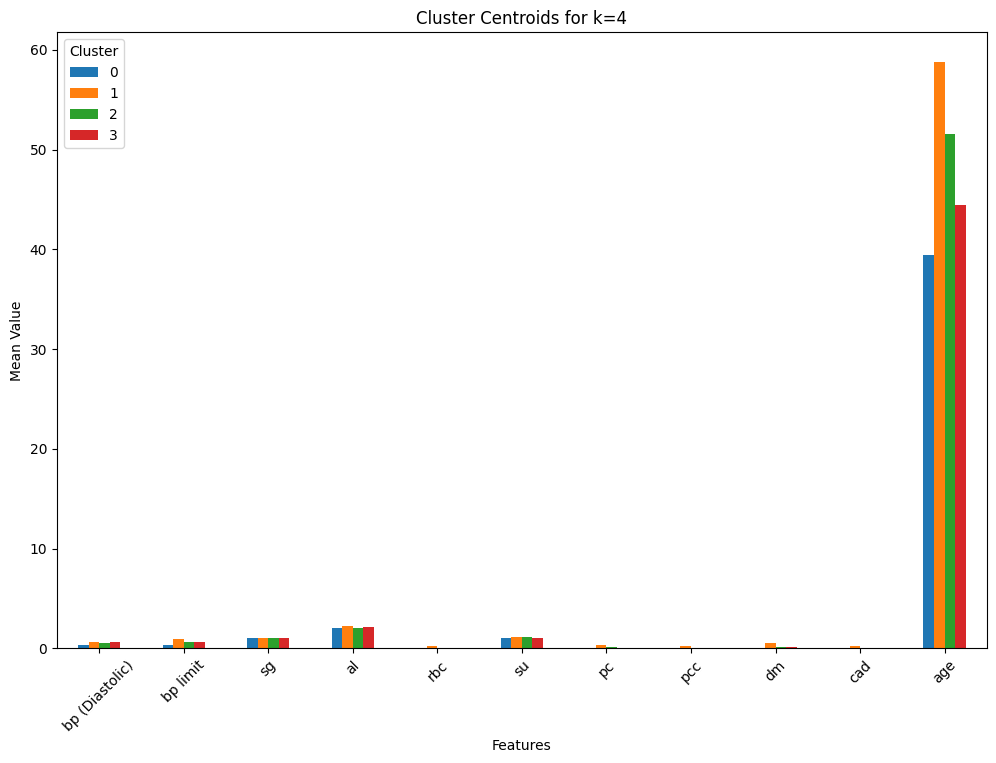

In [ ]:
centroids_df.set_index('Cluster').T.plot(kind='bar', figsize=(12, 8))
plt.title('Cluster Centroids for k=4')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()

Profiling Clusters with Centroids:

In [ ]:
features = ['bp (Diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc',
            'pcc', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'age']

In [ ]:
X = df[features]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
linked = linkage(X_scaled, method='ward')

In [ ]:
k = 4  # Set your desired number of clusters
clusters = fcluster(linked, k, criterion='maxclust')

In [ ]:
df['hierarchical_cluster'] = clusters

In [ ]:
cluster_profile = df.groupby('hierarchical_cluster').mean().reset_index()

In [ ]:
print("Cluster Profiles:")
print(cluster_profile)

Cluster Profiles:
   hierarchical_cluster  Cluster  bp (Diastolic)  bp limit        sg  \
0                     1      2.0        0.476483  0.535742  1.019645   
1                     2      0.0        0.592593  0.907407  1.015852   

         al     class       rbc        su       pc  ...       htn        dm  \
0  2.045869  0.759104  0.027635  1.044444  0.04245  ...  0.052189  0.085237   
1  2.222222  0.037037  0.203704  1.101852  0.37037  ...  0.666667  0.564815   

        cad     appet        pe       ane         grf     stage  affected  \
0  0.000000  0.062678  0.049858  0.014815  128.660478  0.318519  0.240896   
1  0.203704  0.305556  0.268519  0.277778   31.161307  3.046296  0.962963   

         age  
0  45.137192  
1  58.828704  

[2 rows x 31 columns]


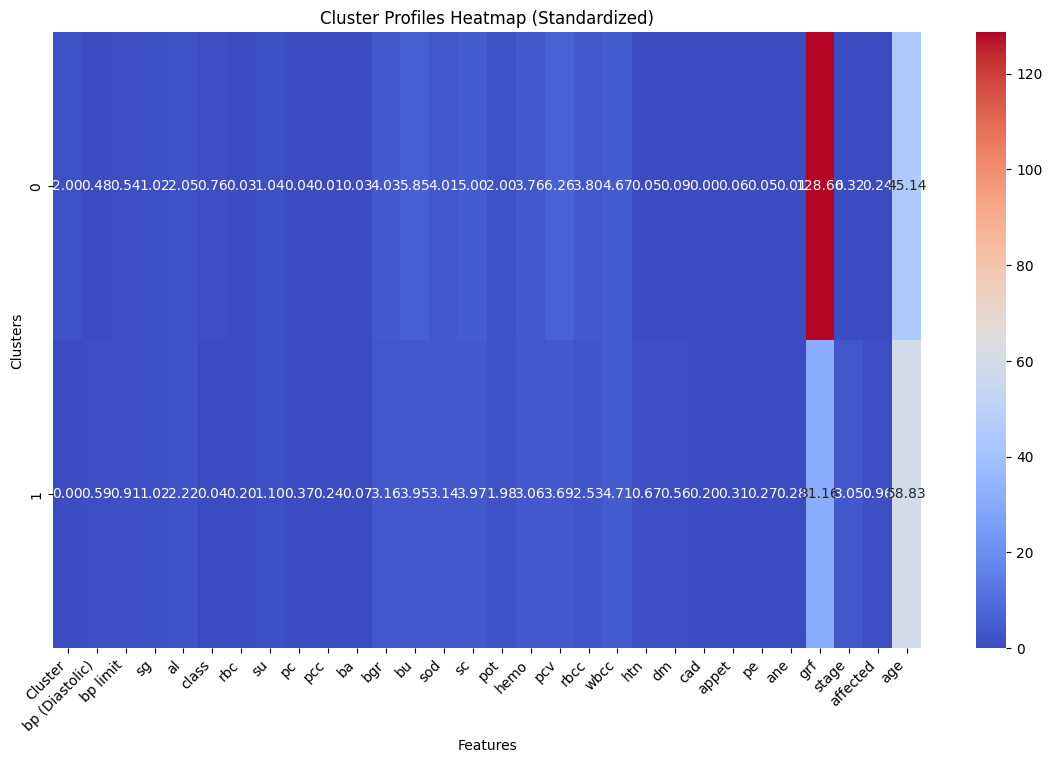

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profile.drop(columns='hierarchical_cluster'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cluster Profiles Heatmap (Standardized)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha="right")
plt.show()

Rador plot:

In [ ]:
categories = list(cluster_profile.columns[1:])  # Exclude cluster labels
values = cluster_profile.loc[:, categories].values

In [ ]:
num_vars = len(categories)

In [ ]:
values = np.concatenate((values, values[:,[0]]), axis=1)  # Repeat the first value to close the circle
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()  # Calculate angles for each axis
angles += angles[:1]

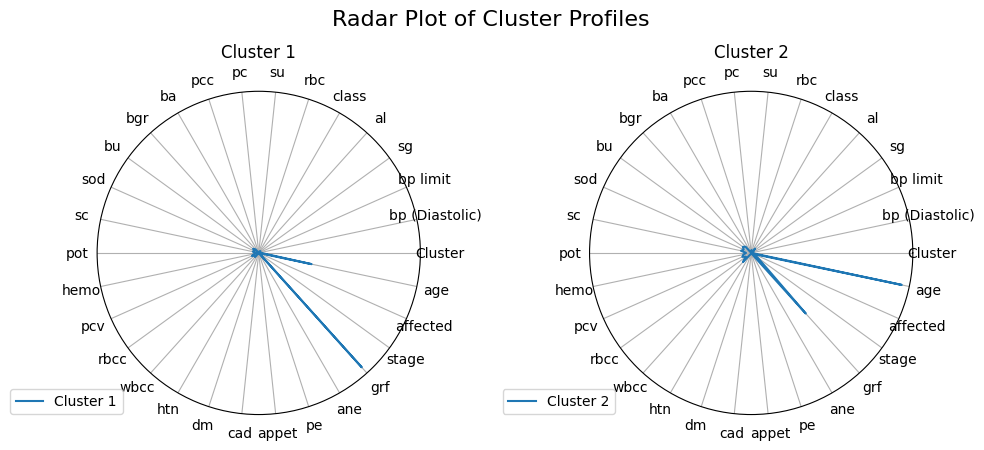

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(len(values)):
    plt.subplot(2, 2, i + 1, polar=True)  # Adjust the number of subplots based on the number of clusters
    plt.fill(angles, values[i], alpha=0.25)  # Fill the area
    plt.plot(angles, values[i], label=f'Cluster {int(cluster_profile["hierarchical_cluster"][i])}')  # Plot the line
    plt.title(f'Cluster {int(cluster_profile["hierarchical_cluster"][i])}')
    plt.xticks(angles[:-1], categories, color='black')  # Set the labels
    plt.yticks([])  # Disable y-ticks for clarity
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.suptitle('Radar Plot of Cluster Profiles', fontsize=16)
plt.tight_layout()
plt.show()

DBSCAN:

In [ ]:
X_scaled = scaler.fit_transform(X)

In [161]:
eps_values = [0.5, 0.7, 1.0, 1.2]
min_samples_values = [3, 5, 7]

In [162]:
best_eps = 0
best_min_samples = 0
largest_cluster_count = 0

In [163]:
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_data)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        if n_clusters > largest_cluster_count:
            largest_cluster_count = n_clusters
            best_eps = eps
            best_min_samples = min_samples

In [165]:
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")

Best eps: 1.2, Best min_samples: 3


In [176]:
dbscan = DBSCAN(eps=2.0, min_samples=3)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

In [177]:
filtered_data = df[df['dbscan_cluster'] != -1]

In [178]:
dbscan_cluster_profile = filtered_data.groupby('dbscan_cluster').mean().reset_index()

In [179]:
print("DBSCAN Cluster Profile:")
print(dbscan_cluster_profile)

DBSCAN Cluster Profile:
Empty DataFrame
Columns: [dbscan_cluster, Cluster, bp (Diastolic), bp limit, sg, al, class, rbc, su, pc, pcc, ba, bgr, bu, sod, sc, pot, hemo, pcv, rbcc, wbcc, htn, dm, cad, appet, pe, ane, grf, stage, affected, age, hierarchical_cluster]
Index: []

[0 rows x 32 columns]


In [175]:
noise_ratio = (df['dbscan_cluster'] == -1).sum() / len(df)
print(f"Noise Ratio: {noise_ratio:.2%}")

Noise Ratio: 100.00%


Gaussian Mixture Models:

In [181]:
features = ['bp (Diastolic)', 'bp limit', 'sg', 'al', 'class', 'rbc', 'su', 'pc', 'pcc', 'ba', 'bgr', 'bu',
            'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc', 'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
            'grf', 'stage', 'affected', 'age']

In [182]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[features])

In [183]:
n_components = 4

In [184]:
gmm = GaussianMixture(n_components=n_components, random_state=0)
df['gmm_cluster'] = gmm.fit_predict(scaled_df)

Cluster Profiling:

In [186]:
gmm_cluster_profile = df.groupby('gmm_cluster').mean().reset_index()
print("GMM Cluster Profile:")
print(gmm_cluster_profile)

GMM Cluster Profile:
   gmm_cluster  Cluster  bp (Diastolic)  bp limit        sg        al  \
0            0      2.0        0.488889  0.666667  1.018356  2.022222   
1            1      0.0        0.592593  0.907407  1.015852  2.222222   
2            2      1.0        0.363636  0.363636  1.020773  2.000000   
3            3      3.0        0.576923  0.576923  1.019808  2.115385   

      class       rbc        su        pc  ...       cad     appet        pe  \
0  0.644444  0.044444  1.133333  0.088889  ...  0.000000  0.111111  0.111111   
1  0.037037  0.203704  1.101852  0.370370  ...  0.203704  0.305556  0.268519   
2  0.863636  0.000000  1.000000  0.000000  ...  0.000000  0.000000  0.000000   
3  0.769231  0.038462  1.000000  0.038462  ...  0.000000  0.076923  0.038462   

        ane         grf     stage  affected        age  hierarchical_cluster  \
0  0.044444   73.873218  0.955556  0.355556  51.544444                   1.0   
1  0.277778   31.161307  3.046296  0.962963  58.8287

Cluster 1 (gmm_cluster 1) has a higher bp (Diastolic) mean compared to other clusters, which may indicate higher blood pressure conditions in individuals within this cluster.

Visualization of GMM Clusters

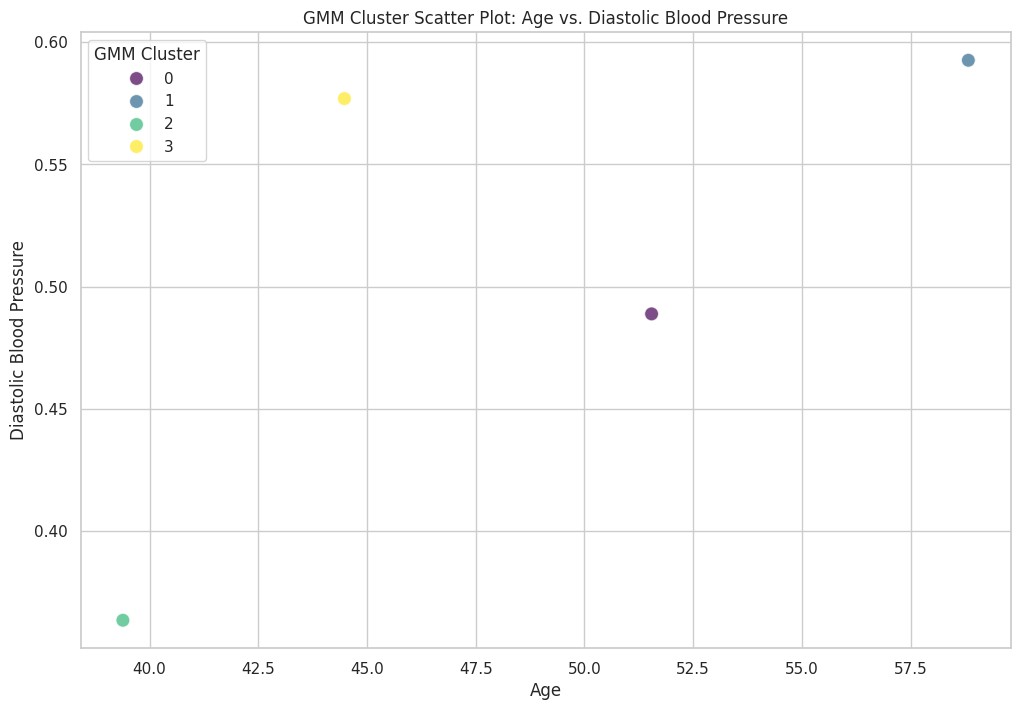

In [187]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='age', y='bp (Diastolic)', hue='gmm_cluster', palette='viridis', s=100, alpha=0.7)
plt.title('GMM Cluster Scatter Plot: Age vs. Diastolic Blood Pressure')
plt.xlabel('Age')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='GMM Cluster')
plt.show()

Rador plot:

In [188]:
def plot_radar_chart(cluster_data, cluster_num):
    categories = list(cluster_data.columns[2:])
    values = cluster_data.mean().values[2:]
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='red', alpha=0.25)
    ax.plot(angles, values, color='red', linewidth=2)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_title(f'Radar Plot for GMM Cluster {cluster_num}', size=15)
    plt.show()

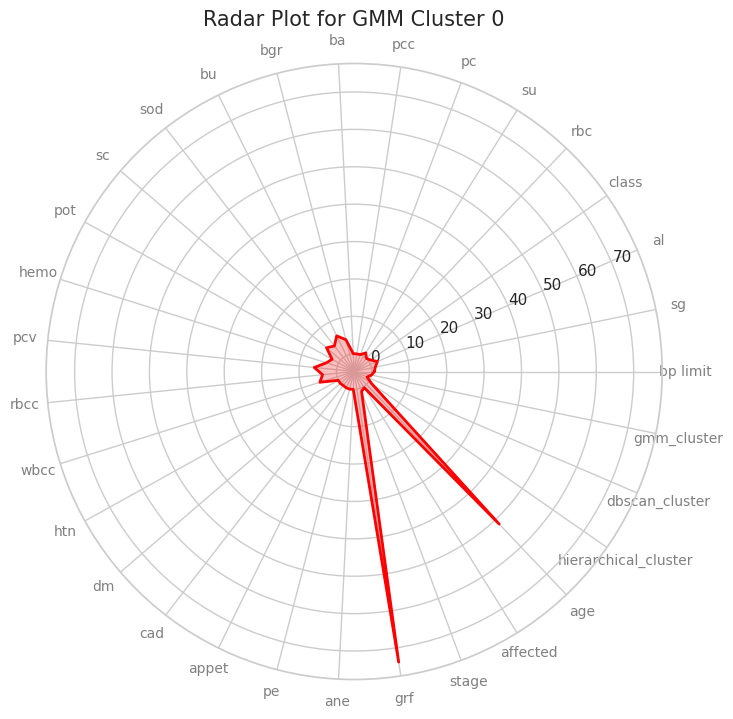

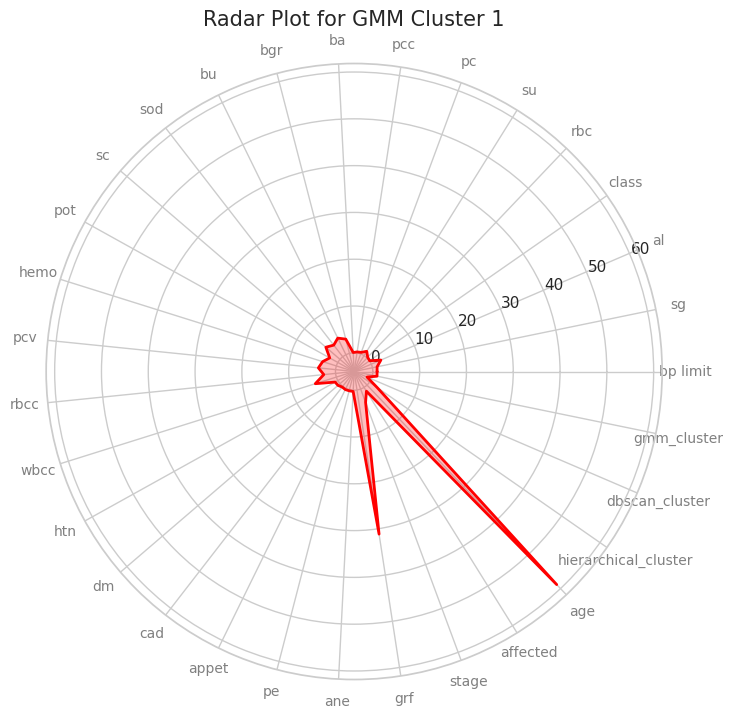

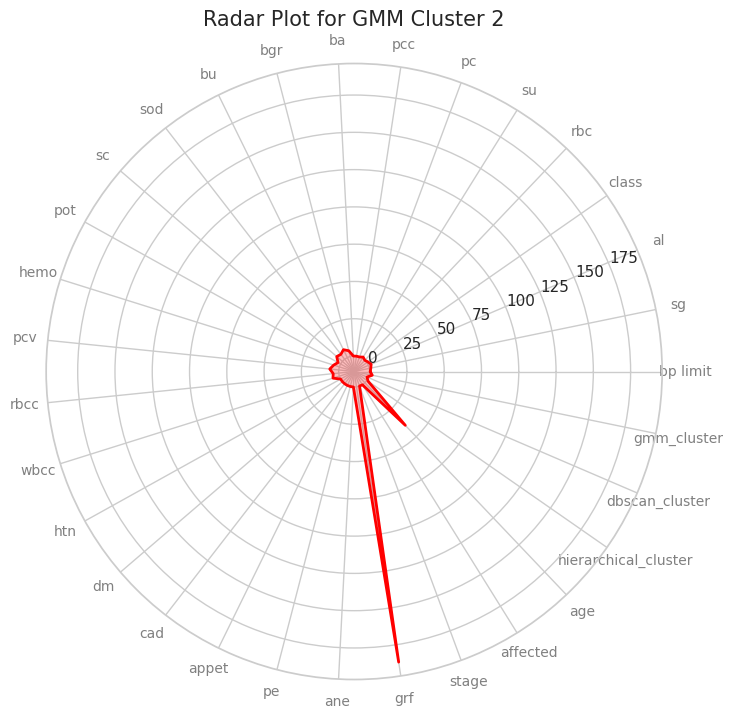

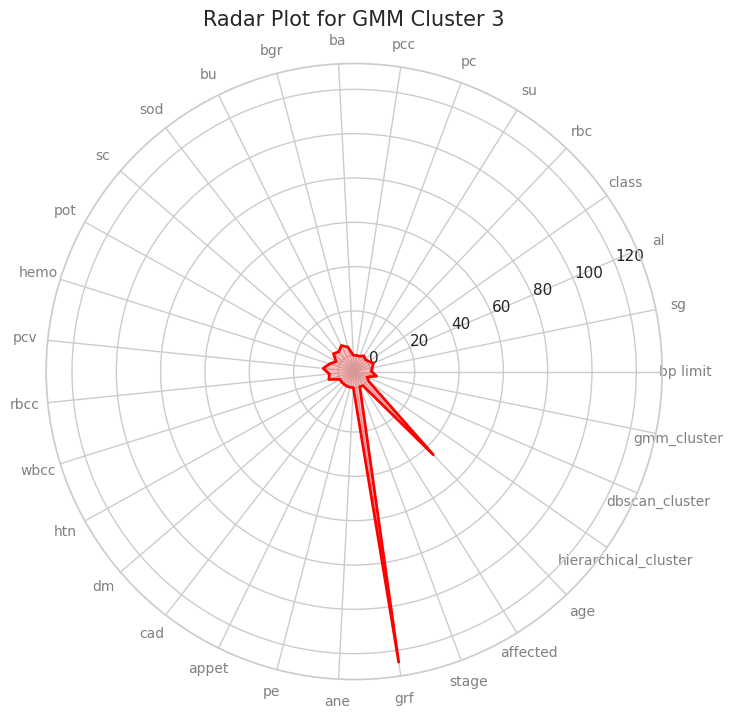

In [189]:
for cluster_num in range(len(df['gmm_cluster'].unique())):
    cluster_data = df[df['gmm_cluster'] == cluster_num]
    plot_radar_chart(cluster_data, cluster_num)

scatter plot comparing GMM and DBSCAN clusters:

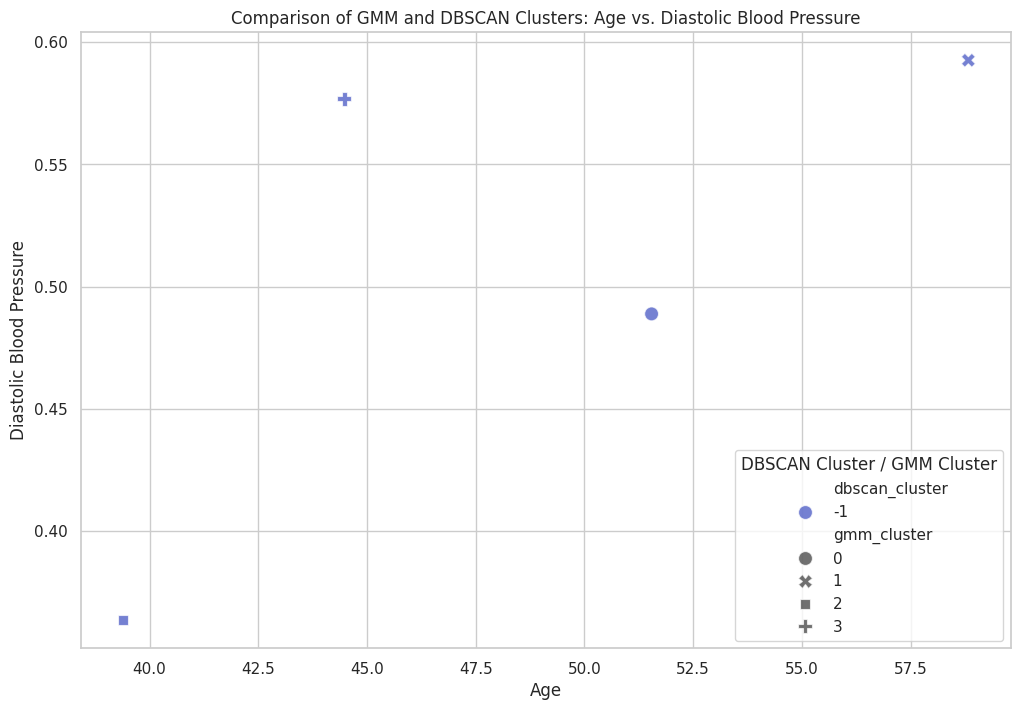

In [191]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='age', y='bp (Diastolic)', hue='dbscan_cluster', palette='coolwarm', style='gmm_cluster', s=100, alpha=0.7)
plt.title('Comparison of GMM and DBSCAN Clusters: Age vs. Diastolic Blood Pressure')
plt.xlabel('Age')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='DBSCAN Cluster / GMM Cluster')
plt.show()

Agglomerative Clustering:

In [199]:
features = ['bp (Diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc', 'pcc', 'ba', 'bgr',
            'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc', 'wbcc', 'htn', 'dm',
            'cad', 'appet', 'pe', 'ane', 'grf', 'age']

In [200]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [201]:
n_clusters = 4

In [202]:
agglo_clustering = AgglomerativeClustering(n_clusters=n_clusters)

In [203]:
df['agglo_cluster'] = agglo_clustering.fit_predict(X_scaled)

In [204]:
agglo_cluster_profile = df.groupby('agglo_cluster').mean().reset_index()
agglo_cluster_profile

,agglo_cluster,Cluster,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,...,appet,pe,ane,grf,stage,affected,age,hierarchical_cluster,dbscan_cluster,gmm_cluster
0,0,3.0,0.576923,0.576923,1.019808,2.115385,0.769231,0.038462,1.000000,0.038462,...,0.076923,0.038462,0.000000,125.344942,0.000000,0.230769,44.480769,1.0,-1.0,3.0
1,1,1.0,0.363636,0.363636,1.020773,2.000000,0.863636,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,186.763273,0.000000,0.136364,39.386364,1.0,-1.0,2.0
2,2,2.0,0.488889,0.666667,1.018356,2.022222,0.644444,0.044444,1.133333,0.088889,...,0.111111,0.111111,0.044444,73.873218,0.955556,0.355556,51.544444,1.0,-1.0,0.0
3,3,0.0,0.592593,0.907407,1.015852,2.222222,0.037037,0.203704,1.101852,0.370370,...,0.305556,0.268519,0.277778,31.161307,3.046296,0.962963,58.828704,2.0,-1.0,1.0


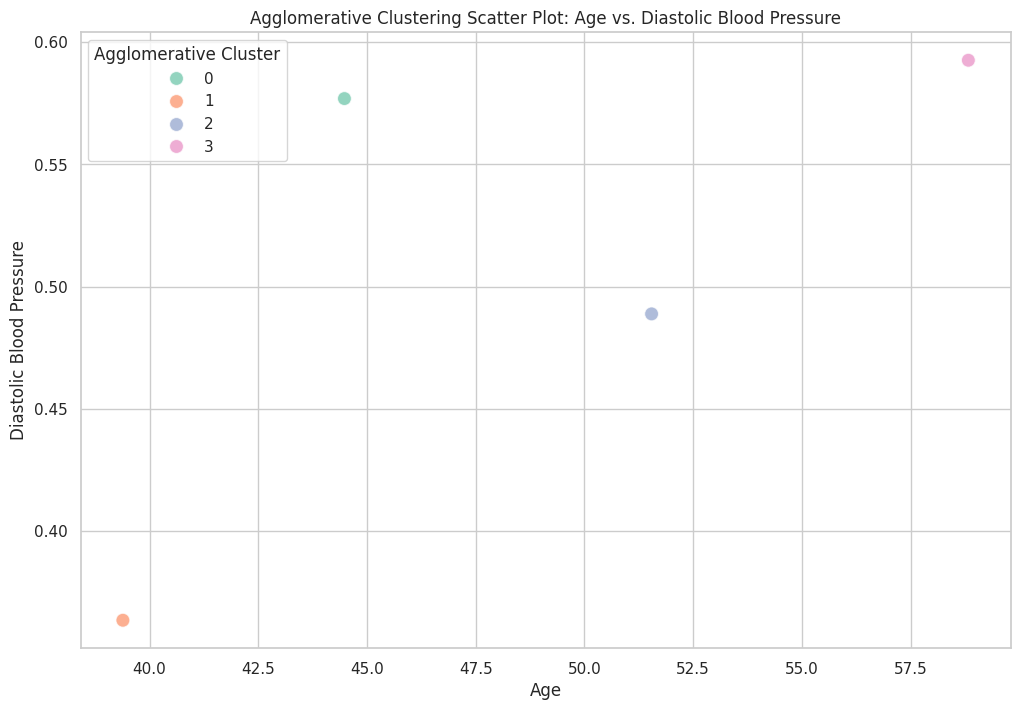

In [205]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='age', y='bp (Diastolic)', hue='agglo_cluster', palette='Set2', s=100, alpha=0.7)
plt.title('Agglomerative Clustering Scatter Plot: Age vs. Diastolic Blood Pressure')
plt.xlabel('Age')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='Agglomerative Cluster')
plt.show()

In [225]:
def plot_radar_chart(df, cluster_num):
  features = ['bp (Diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc',
                'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo',
                'pcv', 'rbcc', 'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe',
                'ane', 'grf', 'age']
  cluster_means = cluster_data[features].mean().values
  cluster_means = np.concatenate((cluster_means, [cluster_means[0]]))  # Close the loop
  num_vars = len(features)
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
  angles += angles[:1]
  fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
  ax.fill(angles, cluster_means, color='blue', alpha=0.25)
  ax.plot(angles, cluster_means, color='blue', linewidth=2)
  ax.set_yticklabels([])
  ax.set_xticks(angles[:-1])  # Exclude the last angle for labels
  ax.set_xticklabels(features, fontsize=10)
  plt.title(f'Agglomerative Cluster {cluster_num}', size=15, color='blue', weight='bold')
  plt.show()

In [226]:
n_clusters = df['agglo_cluster'].nunique()

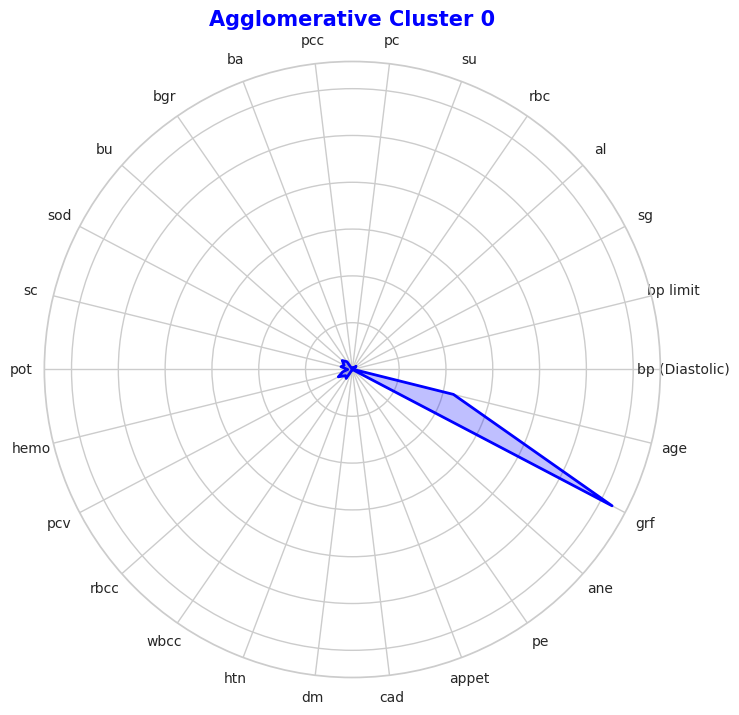

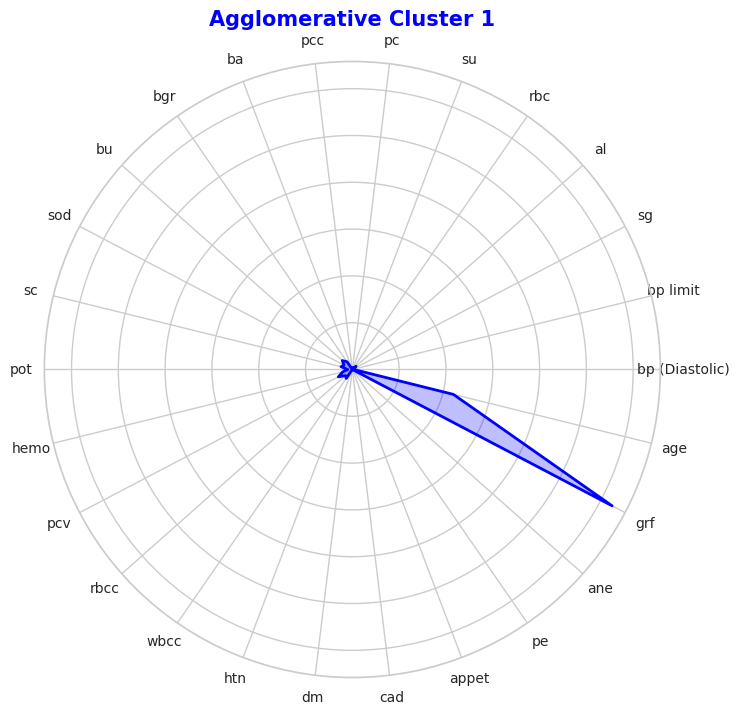

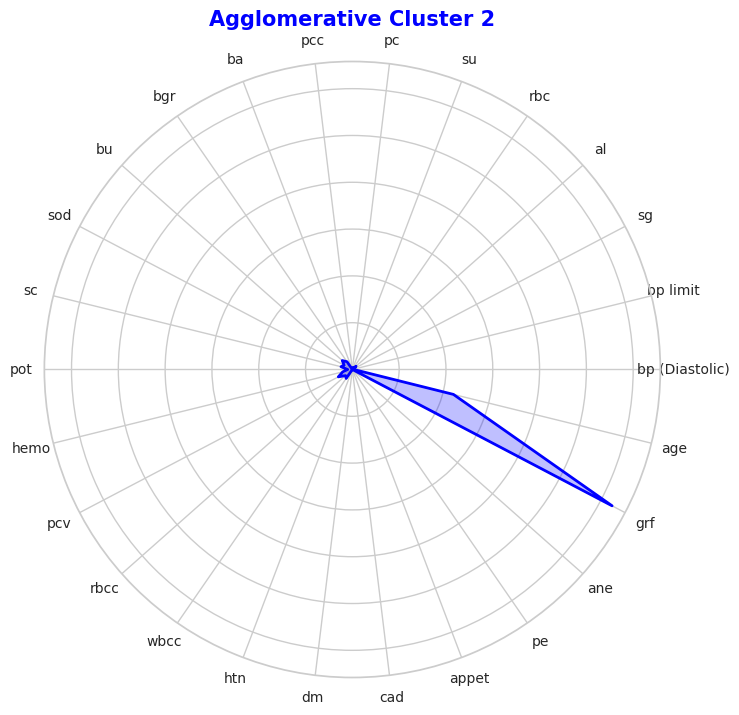

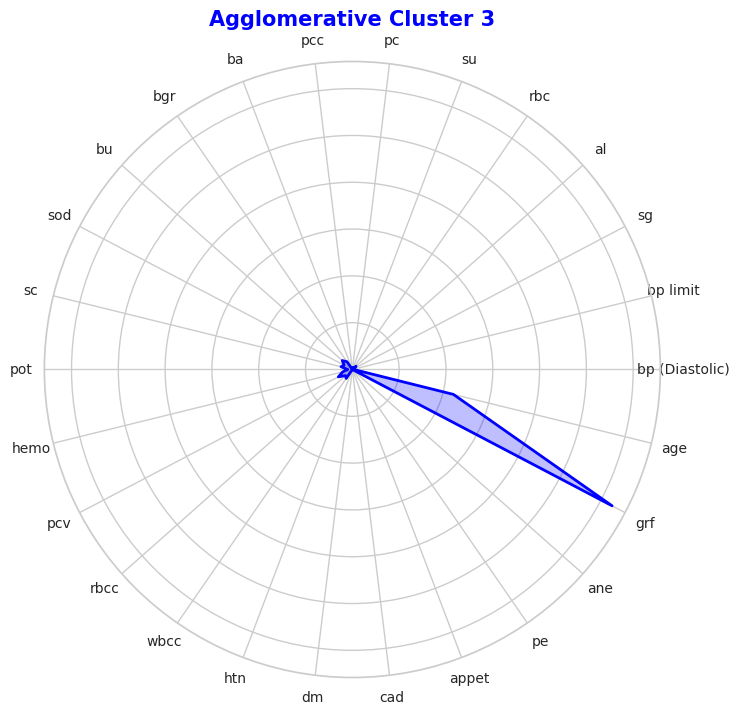

In [227]:
for cluster_num in range(n_clusters):
    cluster_df = df[df['agglo_cluster'] == cluster_num]
    if not cluster_df.empty:
        plot_radar_chart(cluster_df, cluster_num)

Predictive Modeling:

In [229]:
print(df.head())
print(df.columns)

   Cluster  bp (Diastolic)  bp limit        sg        al     class       rbc  \
0        0        0.592593  0.907407  1.015852  2.222222  0.037037  0.203704   
1        1        0.363636  0.363636  1.020773  2.000000  0.863636  0.000000   
2        2        0.488889  0.666667  1.018356  2.022222  0.644444  0.044444   
3        3        0.576923  0.576923  1.019808  2.115385  0.769231  0.038462   

         su        pc       pcc  ...        pe       ane         grf  \
0  1.101852  0.370370  0.240741  ...  0.268519  0.277778   31.161307   
1  1.000000  0.000000  0.000000  ...  0.000000  0.000000  186.763273   
2  1.133333  0.088889  0.022222  ...  0.111111  0.044444   73.873218   
3  1.000000  0.038462  0.000000  ...  0.038462  0.000000  125.344942   

      stage  affected        age  hierarchical_cluster  dbscan_cluster  \
0  3.046296  0.962963  58.828704                     2              -1   
1  0.000000  0.136364  39.386364                     1              -1   
2  0.955556  0.3

In [241]:
unique_values = df['stage'].unique()
print("Unique values in target variable (stage):", unique_values)

Unique values in target variable (stage): [3.0462963  0.         0.95555556]


In [242]:
print("Data type of target variable:", df['stage'].dtype)

Data type of target variable: float64


In [243]:
def categorize_stage(value):
    if value <= 1.0:  # Low Risk: Values less than or equal to 1
        return 'Low Risk'
    elif 1.0 < value <= 2.0:  # Medium Risk: Values between 1 and 2
        return 'Medium Risk'
    else:  # High Risk: Values greater than 2
        return 'High Risk'

In [244]:
df['stage'] = df['stage'].apply(categorize_stage)

In [245]:
X = df.drop(columns=['stage'])
y = df['stage']

In [246]:
y = y.astype('category')

In [247]:
print("Updated unique values in target variable (stage):", y.unique())

Updated unique values in target variable (stage): ['High Risk', 'Low Risk']
Categories (2, object): ['High Risk', 'Low Risk']
